In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import particlesim.api
import particlesim.helpers_for_tests
import particlesim.utils.xyz
import particlesim.utils.config_parser
import particlesim.utils.conversion
from particlesim.k_cython import fast_distances, fast_distances_cpdef
from particlesim.neighbouring import NeighbouringCellLinkedLists, NeighbouringPrimitiveLists
import time
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def create_system_conf_with_na_and_cl(num_na, num_cl, box_size = 12, neighbouring=False):
    particles = particlesim.helpers_for_tests.create_positions(box_size=box_size,number_of_particles=num_na+num_cl)
    na = {'sigma':1.21496,'epsilon':0.0469,'charge':1}
    cl = {'sigma':2.02234, 'epsilon':0.15,'charge':-1.0}
    return particlesim.api.SystemConfiguration(xyz=particles, 
                                                      sigmas=([na['sigma']]*num_na)+([cl['sigma']]*num_cl),
                                                      epsilons=[na['epsilon']]*num_na+[cl['epsilon']]*num_cl,
                                                      charges=[na['charge']]*num_na+[cl['charge']]*num_cl,
                                                      box_size=box_size, neighbouring=neighbouring)

<IPython.core.display.Javascript object>


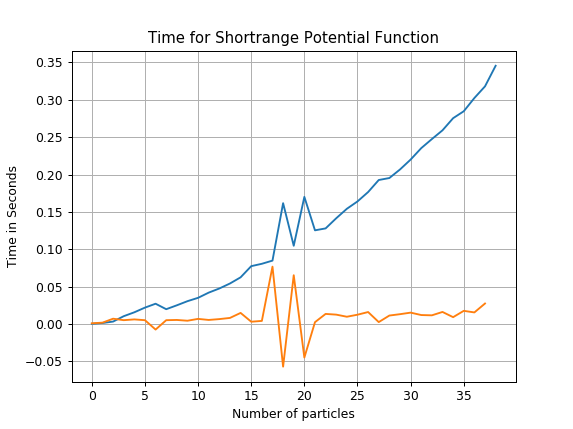

In [5]:
"""This is the ENTIRE SHORTRANGE FUNCTION!!! Fast cython neighborlists but ALWAYS N^2 RUNTIME"""
times = []
N = 400
for i in range(10,N,N//40):
    sys_conf = create_system_conf_with_na_and_cl(i//2,i//2,16,neighbouring=False)
    shorty = sys_conf._total_potential.shortrange
    st = time.clock()
    pot = shorty.shortrange(sys_conf.xyz)
    end = time.clock()
    times.append(end-st)
    #print(i, "particles, time: ", end-st, " potential= ", pot)
plt.close()
plt.title("Time for Shortrange Potential Function")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
times = np.array(times)
plt.plot(times)
plt.plot(times[1:]-times[:-1])
plt.grid()

<IPython.core.display.Javascript object>


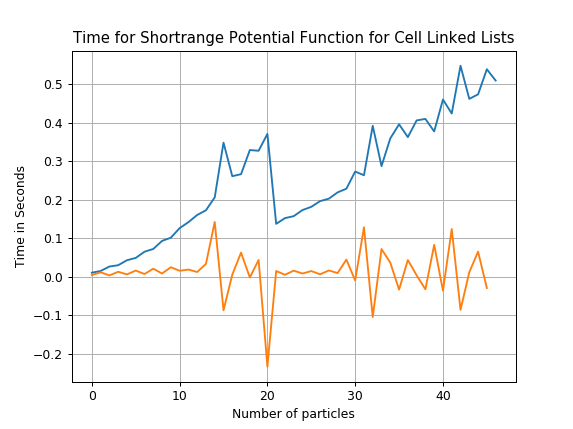

In [8]:
"""This is the ENTIRE SHORTRANGE FUNCTION!!! Python CellLL but ALWAYS N^2 RUNTIME"""
times = []
N = 150
for i in range(10,N,(N//40)):
    # means we're using cell linked lists
    sys_conf = create_system_conf_with_na_and_cl(i//2,i//2,16,neighbouring=True)
    shorty = sys_conf._total_potential.shortrange
    st = time.clock()
    pot = shorty.shortrange(sys_conf.xyz)
    end = time.clock()
    times.append(end-st)
    #print(i, "particles, time: ", end-st, " potential= ", pot)
plt.close()
plt.title("Time for Shortrange Potential Function for Cell Linked Lists")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
times = np.array(times)
plt.plot(times)
plt.plot(times[1:]-times[:-1])
plt.grid()
plt.show()

Time:  0.006115000000008308
Time:  0.05163699999999949
Time:  0.1185040000000015
Time:  0.1538409999999999
Time:  0.25383999999999673
Time:  0.37946200000000374
Time:  0.5817120000000102
Time:  0.7444449999999989
Time:  0.7991489999999999
Time:  1.1125499999999988
Time:  1.317766000000006
Time:  1.7611260000000044


<IPython.core.display.Javascript object>


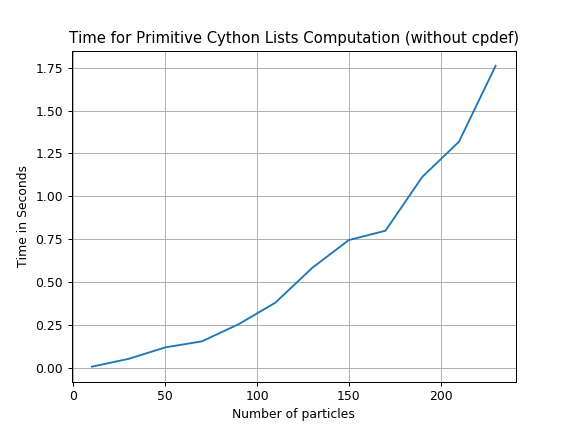

In [7]:
"""This is a Primitive List Neighbour Structure in Python"""
box_len = 5
nr_part = 250
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    #dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    neigh_list = NeighbouringPrimitiveLists(pos, 1.2, 5)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Primitive Cython Lists Computation (without cpdef)")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  2.4999999993724487e-05
Time:  5.699999999819738e-05
Time:  0.00014799999999581814
Time:  0.00020399999999654028
Time:  0.00033600000000433283
Time:  0.00027700000001118497
Time:  0.00037299999999618194
Time:  0.00048799999999005195
Time:  0.0007030000000156633
Time:  0.0007850000000075852
Time:  0.0009619999999870288
Time:  0.0012649999999894135
Time:  0.0014579999999853044
Time:  0.0016900000000248383
Time:  0.0019210000000100536
Time:  0.0029469999999776064
Time:  0.0024370000000146774
Time:  0.0033010000000217588
Time:  0.002966000000014901
Time:  0.004345999999998185
Time:  0.003903999999977259
Time:  0.004034000000018523
Time:  0.0045769999999834
Time:  0.004864999999995234
Time:  0.00591700000001083
Time:  0.005672000000004118
Time:  0.006152999999983422
Time:  0.006557000000015023
Time:  0.007404000000008182
Time:  0.0075999999999964984
Time:  0.008230999999994992
Time:  0.009433999999998832
Time:  0.010134999999991123
Time:  0.01146500000001538
Time:  0.01039999999997576

<IPython.core.display.Javascript object>


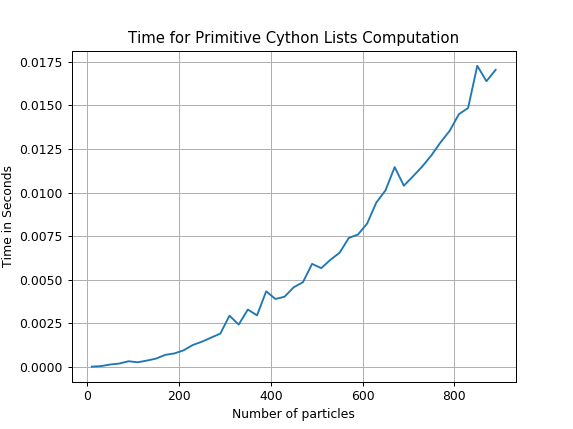

In [10]:
"""This is a Primitive List Structure in CYTHON"""
box_len = 5
nr_part = 900
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    fast_distances_cpdef(pos, box_len, dists)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Primitive Cython Lists Computation")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  0.004498999999981379
Time:  0.04286100000001625
Time:  0.0871569999999906
Time:  0.15390800000000127
Time:  0.23383300000000418
Time:  0.37453300000001377
Time:  0.5081470000000081
Time:  0.6538940000000082
Time:  0.8981630000000109
Time:  1.0109510000000057
Time:  1.3333279999999945
Time:  1.4703130000000044
Time:  1.6680980000000147
Time:  1.992477000000008
Time:  2.2481679999999926
Time:  2.582788999999991
Time:  2.8249099999999885
Time:  3.2903239999999983
Time:  3.4874189999999885
Time:  4.145990000000012
Time:  4.642695000000003
Time:  6.3799800000000175
Time:  5.557607000000019
Time:  5.999121000000002
Time:  6.2066749999999615


<IPython.core.display.Javascript object>


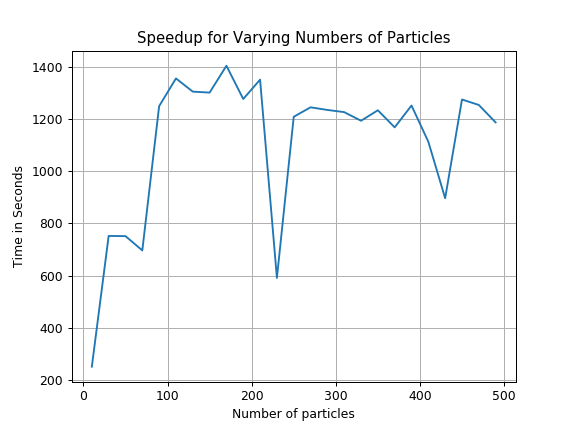

In [13]:
"""Achieved Speedup"""
box_len = 5
nr_part = 300
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    fast_distances_cpdef(pos, box_len, dists)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    st = time.clock()
    neigh_list = NeighbouringPrimitiveLists(pos, 1.2, box_len)
    end = time.clock()
    times[-1] = (end-st)*1.0/times[-1]
    print("Time: ", end-st)
    
plt.close()
plt.title("Speedup for Varying Numbers of Particles")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
plt.plot(nr_particles, times)
plt.grid()
plt.show()

Time:  0.0008100000000013097
Time:  0.0009709999999927277
Time:  0.0013950000000022555
Time:  0.0017889999999738393
Time:  0.002426000000014028
Time:  0.002846000000033655
Time:  0.003747999999973217
Time:  0.0036999999999807187
Time:  0.005126000000018394
Time:  0.005462999999963358
Time:  0.002296000000001186
Time:  0.0023939999999811334
Time:  0.0025420000000053733
Time:  0.002751999999986765
Time:  0.0028599999999983083
Time:  0.007903000000055727
Time:  0.0033819999999877837
Time:  0.009066000000018448
Time:  0.009741999999960171
Time:  0.01045699999997396
Time:  0.004462000000046373
Time:  0.011660000000006221
Time:  0.006843000000003485
Time:  0.00924800000001369
Time:  0.008274999999969168
Time:  0.008692999999993845
Time:  0.009485999999981232
Time:  0.005205999999986943
Time:  0.005446000000006279
Time:  0.005502000000035423
Time:  0.0059560000000260516
Time:  0.010685999999964224
Time:  0.0060330000000021755
Time:  0.006581000000039694
Time:  0.006420999999988908
Time:  0.01

<IPython.core.display.Javascript object>


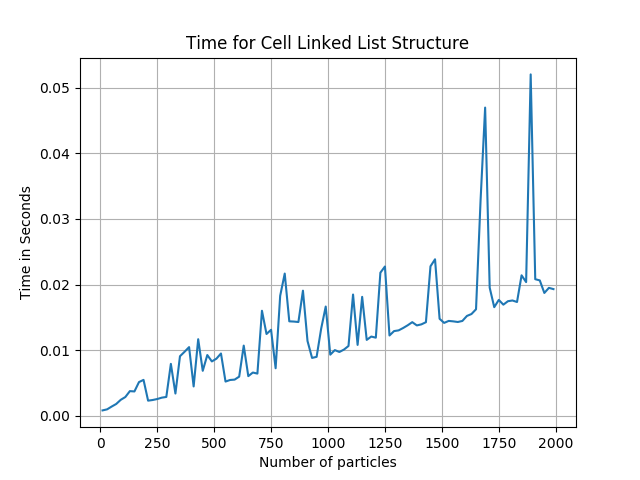

In [36]:
"""This is a CELL LINKED List Neighbour Structure in Python"""
box_len = 10
nr_part = 2000
nr_particles, times = [], []
for i in range(10, nr_part, 20):
    #dists = np.zeros((i,i))
    #pos = np.random.rand(nr_part,3)*box_len
    pos = np.arange(i*3).reshape(i,3).astype("float")%box_len
    
    st = time.clock()
    neigh_list = NeighbouringCellLinkedLists(pos, 1.2, box_len)
    end = time.clock()
    nr_particles.append(i); times.append(end-st)
    print("Time: ", end-st)
    
plt.close()
plt.title("Time for Cell Linked List Structure")
plt.ylabel("Time in Seconds")
plt.xlabel("Number of particles")
nr_particles = np.array(nr_particles); times = np.array(times)
times2 = (times[2:]+times[1:-1]+times[:-2])/3.0
#plt.plot(nr_particles[:-2], times2)
plt.plot(nr_particles, times)
plt.grid()
plt.show()